[Leo's Home page](https://leomrocha.github.com) -- [Github Page](https://github.com/leomrocha/neural-representations) -- License: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

# Representations of Scalar Values on Non Spiking Networks

[Leonardo M. Rocha](https://leomrocha.github.com)

[Contact Me](https://leomrocha.github.io/contact/)

## Introduction

The goal of the present text is to introduce and explore how to encode and decode *Scalar Values* based on the mechanisms and principles presented in [An Introduction to Scalar Representations in Neural Models](https://leomrocha.github.io/neural-representations/NeuralModels-Introduction.html) but trying to go into a non-spiking networks. 

This document presents a small study on how a scalar value can be encoded by a non-linear function in a Non-Spiking Neural Ensemble and then decoded with a linear function with a few examples.

The following sections expose the source code in between the explanations on what is done. For more exploration and to be able to execute the code the original notebook can be found [here](https://github.com/leomrocha/neural-representations/blob/main/notebooks/ScalarRepresentation_tests.ipynb).

This notebook presents the basic ideas on how to encode and decode values and the precursors of how an ANN can be interpreted and the principles related with a biological neural network from a different point of view that is usually taught.

It is important to note that this notebook does NOT intend to show the techniques used in current ANNs, just take another view on how they can be interpreted. 

The take out of the current notebook is more of an exploration on how to encode and decode values, and that decoding values is not necessarily evident.

## Important Concepts:

These are the concepts that should be retained from the current document or are needed

- **Neural Ensemble**: a set of neurons representing a computation
- **Linear Decoder**: A function that is trained to decode the values encoded by the *Neural Ensemble*
- **Neural Response Curve**: how a neuron encodes (in firing frenquency) to an input value
- **ANNs**:  Artificial Neural Networks, a computation graph that from an input will give an output


In [1]:
import random
import matplotlib.pyplot as plt

from sklearn import linear_model, datasets, svm, metrics
from sklearn.model_selection import train_test_split

import numpy as np
#import pandas as pd

%matplotlib inline

First there is the need to define what a neuron is. In this case it is defined with 3 parameters:
 - two parameters to define a linear function $y = f(x) = ax+b$ and 
 - a threshold for non-linearity called _saturation_ that will be used as the maximum $y$ value that the neuron can handle

Comparing this function with existing ones used in ANNs we can see that it is basically a [Rectifier Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))

A neuron could have different and more complex non-linear response functions, for the current study we limit it to a linear response with a saturation point :)


In [2]:
# Definition of parameter creation

class Neuron(object):
    def __init__(self, a, b, sat):
        self.a = a
        self.b = b
        self.saturation = sat

### Parameter creation 

creating the parameters is a tricky thing, the tuning curves must intersect the values for x=0 and x=1
in a place that represents some interesting value, for this there are several restrictions that follow:

- the tuning curve must intersect the x axis between 0 and 1
- the tuning curve must intersect the y axis for x=0 between 0 and 1
- the tuning curve must intersect the y axis for x=1 between 0 and 1

To do this the conditions are:
- $min_y + |b| <= a <= max_y \mid b<0 $
- $min_y <= |b| <= max_y \mid b>0$
- $a <= -|max_y| \mid b>0$

To add non linearities the $y$ intersection for x=0 and x=1 can be truncated, and we can use the saturation value for $y$.

The _Encoding Neurons Ensemble_ is composed of randomly created neurons which are not trained, the initial random values are are fixed.



In [3]:
def param_creation(min_y_value=0.5, max_y_value=1.5, max_x_value=-1, saturation=None):
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    if (s<0): # TODO show the derivation of this (is easy anyways)
        b = -random.uniform(0,1)
        a = random.uniform(min_y_value - b, max_y_value)
    else:
        a = -random.random()-max_x_value
        b = random.uniform(min_y_value, max_y_value)
    # return Neuron(a,b,saturation)
    return a,b,saturation

The neurons are created with random values but for a function that is contained in a fixed range representing the domain in which the functions operate. 

To ensure that the functions have a good representation and response over the entire domain, instead of randomly creating a and b it can also be done selecting two points $(x,y)$ in the domain and solving for $a$ and $b$.


In [4]:
def neuron_creation(min_y=0.5, max_y=1.5, min_x=-1.0, max_x=1.0, saturation=None):
    """
    This model creates two points, one in x range, one in y range, then decides if a >0 or a<0.
    Depending on the sign (which will be the sign of a), will resolve the linear equation to find 
    a and b
    """
    if(saturation is None):
        saturation = random.uniform(0.8,1.0)
    s = random.choice([-1, 1])
    a=b=0
    # the first point is for y=0 
    x1 = random.uniform(-1, 1)
    y1 = 0
    # the second point is for x=+-1 
    x2 = s
    y2 = random.uniform(min_y,max_y)
    
    a = (y1-y2)/(x1-x2)
    b = y1 - a*x1
    return a,b,saturation
    # return Neuron(a,b,saturation)

There are different possibilities to evaluate the neuron output state, there are two main cases:
- When the neurons saturate to a max value
- When the neurons do not saturate

In [5]:
# Definition of function evaluation

def limited_neuron_evaluator(x, neuron):
    a = neuron.a
    b = neuron.b
    sat=neuron.saturation
    return max(0, min(a*x + b, sat))
    

def neuron_evaluator(x, neuron ):
    a = neuron.a
    b = neuron.b
    sat = neuron.saturation
    return max(0, a*x + b)


A **Neural Ensemble** is just a set of neurons that encodes an input into an output. 

Then to encode an input value there is only the need to evaluate the individual response of each neuron, and the set of responses corresponds to the encoded input value

In [6]:
class Ensemble():
    def __init__(self, n_neurons, min_y=0.5, max_y=1.5, max_x=1,min_x=-1,saturation=None):
        params = [neuron_creation(min_y, max_y, max_x, saturation) for i in range(n_neurons)]
#         print(len(params))
        # separate for matrix operations
        self._a = np.full((1, n_neurons), [i[0] for i in params])
        self._b = np.full((1, n_neurons),[i[1] for i in params])
        self._sat = np.full((1, n_neurons),[i[2] for i in params])
        self.zeros = np.zeros_like(self._a)
#         print("ensemble shape: ", self.zeros.shape)
        
    def encode(self, x):
#         print("encoding shape  ",x.shape)
        xab = np.matmul(x, self._a) + self._b
        enc = np.maximum(self.zeros, xab)
        s_enc = np.maximum(self.zeros, np.minimum(xab, self._sat))
        return enc, s_enc

# Encoding and Decoding Values

This section is dedicated to show some examples of encoding and decoding values to show that this is feasible.

### Encoding curves

In this section there are a few examples of linear encoding curves, other functions can be used for this, for the moment only linear ones are used as an example.

In [7]:
xes  = np.linspace(start=-1.05, stop=1.05, num=100).reshape(-1,1)
# print(xes.shape)
# A Neural Ensemble with different response curves
e = Ensemble(20)

In [8]:
# encoding some values, linear values in this case to see the response
curves, lim_curves = e.encode(xes)

In [9]:
# transposing the values to show them correctly
curves = np.transpose(curves)
lim_curves = np.transpose(lim_curves)


This is a set of randomly created neurons, in this case they can be seen as [Rectified Linear Units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) but any other function can be also used, the idea is to make a random set of function variations big enough to encode any input in an over-represented vector which can later be used to operate and use in a decorder.

In this particular case a set of values will be encoded with the Neuron Ensembles and then decoded with a linear decoding function.

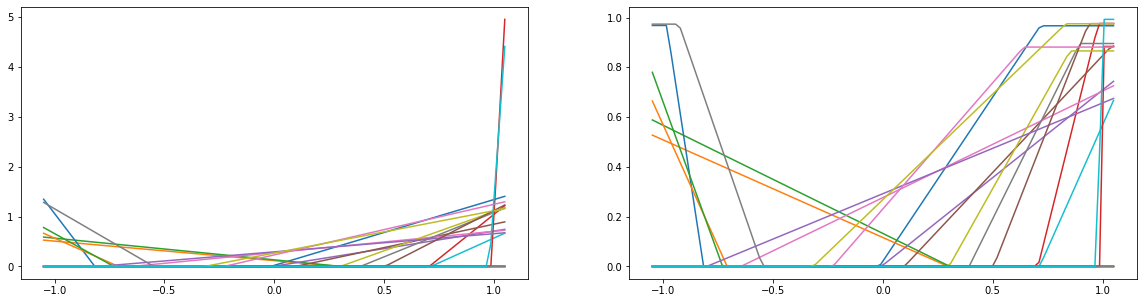

In [10]:
f, axes = plt.subplots(1,2, figsize=(20, 5))
for c in curves:
    axes[0].plot(xes,c)

for c in lim_curves:
    axes[1].plot(xes,c)

Building a few ensembles with more neurons and visualizing how each encodes a sine wave and a linear function, the encodings and decodings are shown with neurons that saturate and neurons that do not saturate.

In [11]:
n_ensambles = 3
ensembles = [Ensemble(20) for i in range(n_ensambles)]

In [12]:
# functions to represent
# xes  = np.linspace(start=-1.05, stop=1.05, num=100).reshape(-1,1)
x = np.linspace(0, 4*np.pi, 1500).reshape(-1,1)
# input currents to give to the neural ensemble
y = np.sin(x) 
# linear function from 0 to 1
ly = np.linspace(0, 1, 1500).reshape(-1,1)
# random  samples, to be used for training and testing
ry = np.random.rand(len(x)).reshape(-1,1)

In [13]:
print(x.shape, y.shape, ly.shape, ry.shape)

(1500, 1) (1500, 1) (1500, 1) (1500, 1)


Now encoding all with saturated and non saturated neurons

In [14]:
%%time 
enc = []
for fx in [ly,y,ry]:
    res = [e.encode(fx) for e in ensembles]
    enc.append(res)

CPU times: user 4.55 ms, sys: 176 µs, total: 4.72 ms
Wall time: 4.67 ms


In [15]:
# selarate the encoded functions
lin_e, sin_e, rand_e = enc

The values to encode:

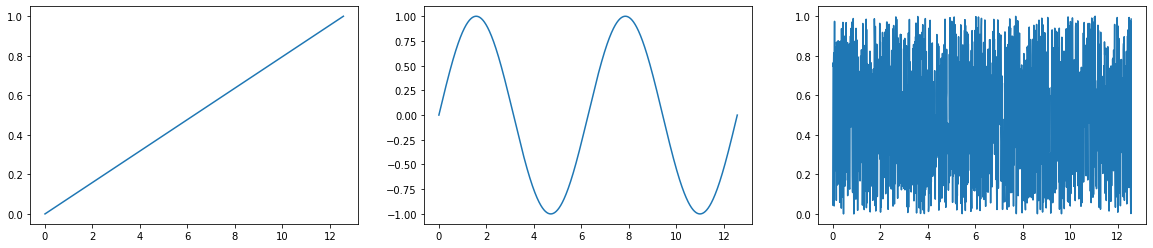

In [16]:
f, axes = plt.subplots(1,3, figsize=(20, 4))
axes[0].plot(x,ly)
axes[1].plot(x,y)
axes[2].plot(x,ry)

In [17]:
def plot_data(data, ns_axe=0, sat_axe=1):
    for i in range(len(data)):
        e = data[i]
        ns_e = np.transpose(e[0])
        sat_e = np.transpose(e[1])
        for c in ns_e:
            axes[ns_axe][i].plot(x,c)
        for c in sat_e:
            axes[sat_axe][i].plot(x,c)

The following plots represent the encoded values fo the inputs, it is easy to observe that the linear, sine and random representations in the encoded domain.

In this case, 3 different Neural Ensembles were randomly created and the input vectors are encoded with each of these ones to show what it looks each encoded function in an over-represented vector.

For each graph the top line represents the embedding without saturation, while the bottom line shows encoded values with neuron saturation.

### Visual representations of the embeddings for different inputs

Encoded Linear values

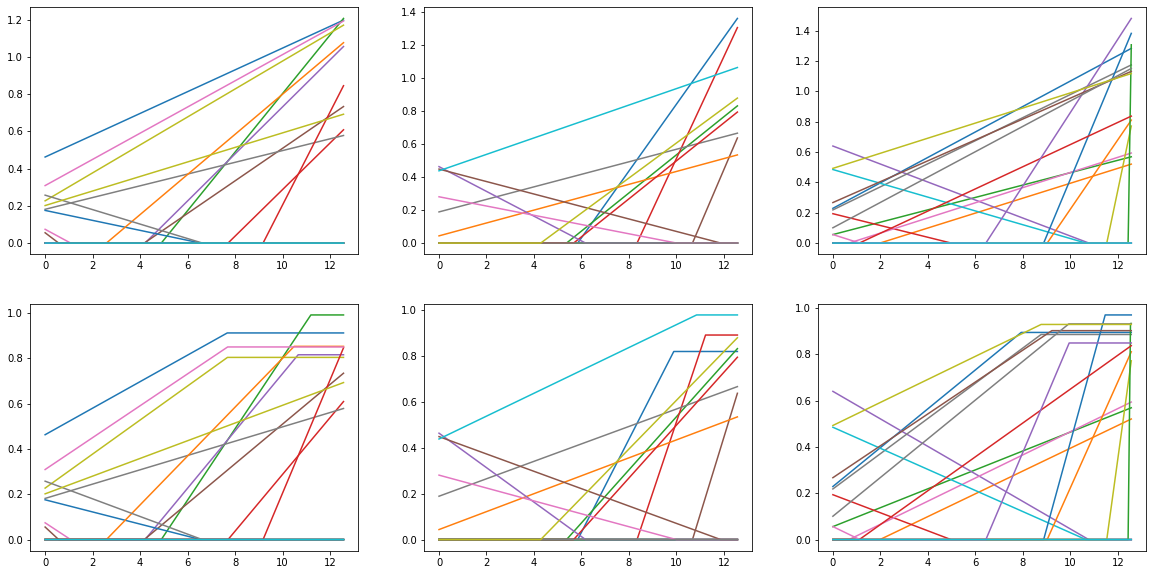

In [18]:
f, axes = plt.subplots(2,3, figsize=(20, 10))
plot_data(lin_e, ns_axe=0, sat_axe=1)

In [19]:
# TODO make a color coded activation graph 

Encoded sine values 

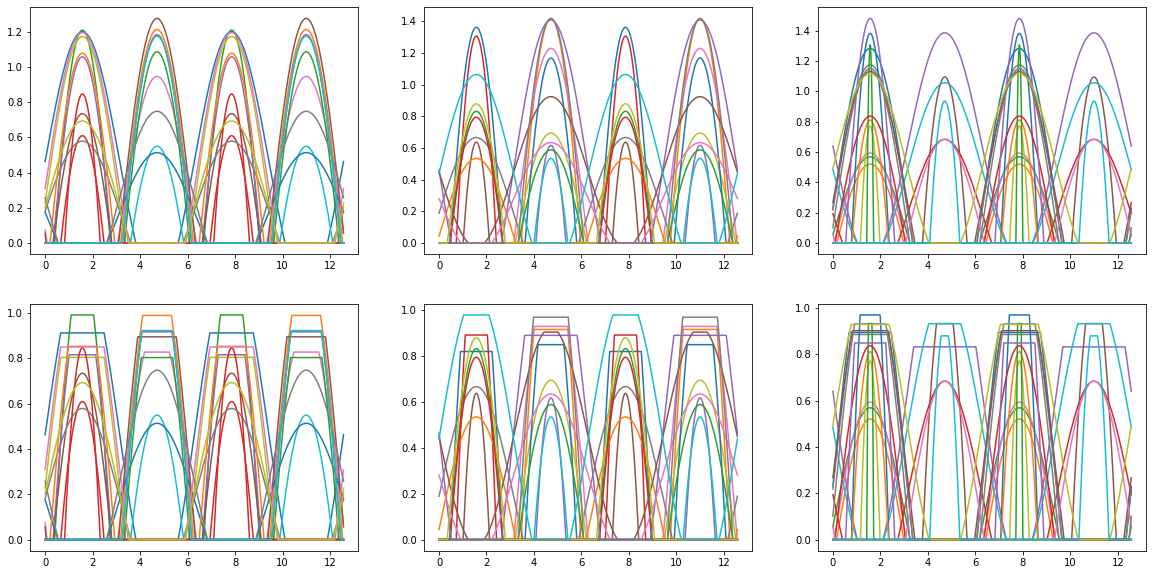

In [20]:
f, axes = plt.subplots(2,3, figsize=(20, 10))
plot_data(sin_e, ns_axe=0, sat_axe=1)

Encoded random values

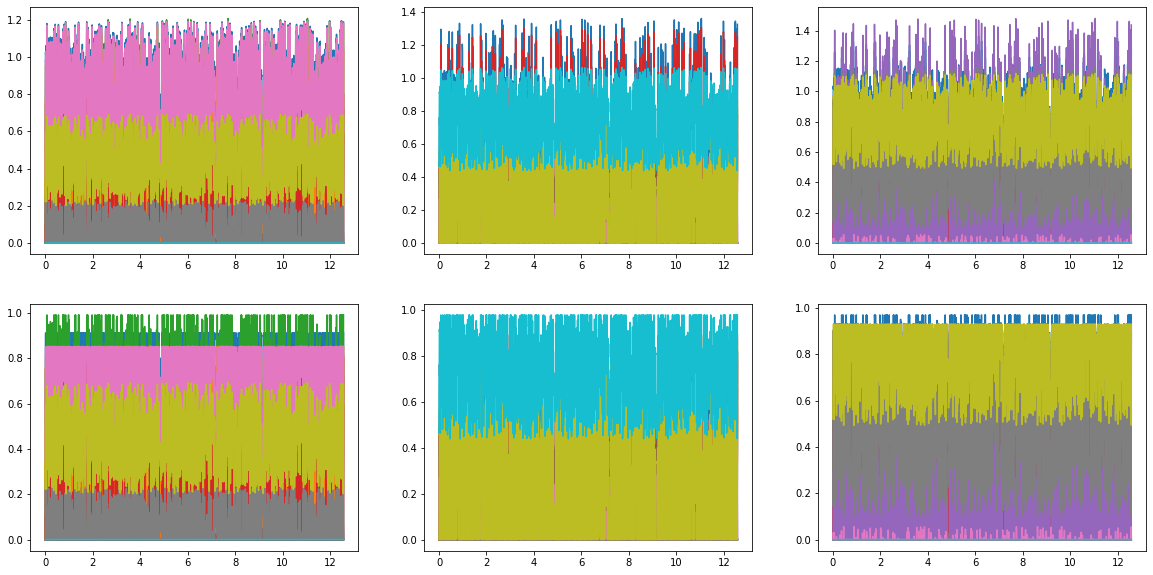

In [21]:
f, axes = plt.subplots(2,3, figsize=(20, 10))
plot_data(rand_e, ns_axe=0, sat_axe=1)

It can be seen that for different random encoder _Neural Ensemble_ the encoded values show different shapes. This does not mean that decoding *any* kind of value from these encoded values will be easy.


## Decoding the encoded vectors

The next step is decoding the values with linear regression (could be another method) and comparing the errors for each encoded value.

Now for each Neural Ensemble, traininig a linear regression decoder for saturated and non saturated neurons.

Given an input an an encoder, find the saturated and non saturated decoders

In [22]:
def train_decoders(x_data, y_data, enc, test_size=0.5):
    y_ns, y_sat = enc.encode(y_data)
    
#     x_train, x_test, y_train, y_test = train_test_split(x_data, y_ns, test_size=test_size)
    x_train, x_test, y_train, y_test = train_test_split(y_ns, x_data, test_size=test_size)
#     print("shapes: ", x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    lm_ns = linear_model.LinearRegression()
    model_ns = lm_ns.fit(x_train, y_train)
    
    x_train_sat, x_test_sat, y_train_sat, y_test_sat = train_test_split(y_sat, x_data, test_size=test_size)
    lm_sat = linear_model.LinearRegression()
    model_sat = lm_sat.fit(x_train_sat, y_train_sat)
    
    # models and the score
    mod_ns = (enc, lm_ns, model_ns, model_ns.score(x_test, y_test))
    mod_sat = (enc, lm_sat, model_sat, model_ns.score(x_test_sat, y_test_sat))

    return mod_ns, mod_sat

Training the decoders

In [23]:
ensembles = [Ensemble(n) for n in [20, 50, 100, 300, 500]]
models_lin = []
models_sin = []
models_rand = []
for ens in ensembles:
    models_lin.append(train_decoders(x, ly, ens))
    models_sin.append(train_decoders(x, y, ens))
    models_rand.append(train_decoders(x, ry, ens))

In [25]:
%%time 
enc = []
for fx in [ly,y,ry]:
    res = [e.encode(fx) for e in ensembles]
    enc.append(res)

CPU times: user 43.5 ms, sys: 7.62 ms, total: 51.1 ms
Wall time: 50.1 ms


In [26]:
lin_e, sin_e, rand_e = enc

In [27]:
def predict_all(models, embeddings):
    decoded = []
    for mod, data in zip(models, embeddings):
    #     print(data[0].shape, data[1].shape)
        # non saturated model [0], fitted model [2]
        dec_ns = mod[0][2].predict(data[0])
        dec_sat = mod[1][2].predict(data[1])
        decoded.append((dec_ns,dec_sat))
    return decoded

Now to show the difference made by different _tuning curves_ and decoders trained with different input data the following plots show:
* 5 different _neural ensembles_ 
* For each neural ensemble 2 different encodings (with and without saturation)
* For each of those there are 3 different decoders applied, trained with linear, sine and random data.


#### Linear input

In [28]:
line_lindec = predict_all(models_lin, lin_e)
line_sindec = predict_all(models_sin, lin_e)
line_randdec = predict_all(models_rand, lin_e)

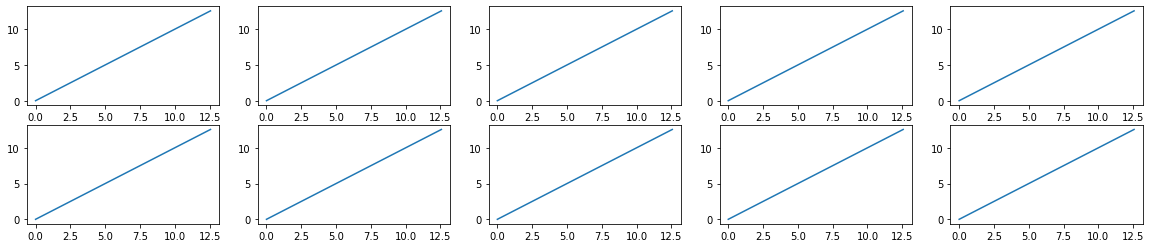

In [29]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(line_lindec, ns_axe=0, sat_axe=1)

This linear decodings are too easy, with any 2 points of the input, and knowing that the input is a linear function it can be perfectly decoded.

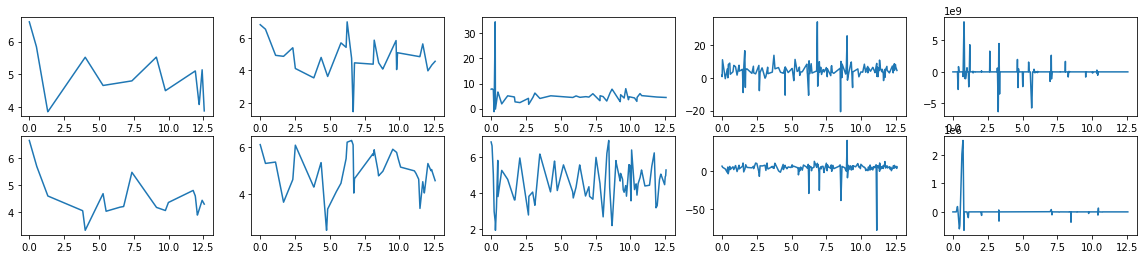

In [30]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(line_sindec, ns_axe=0, sat_axe=1)

In this case a decoder trained with a sine wave is trying to decode a linear input function.

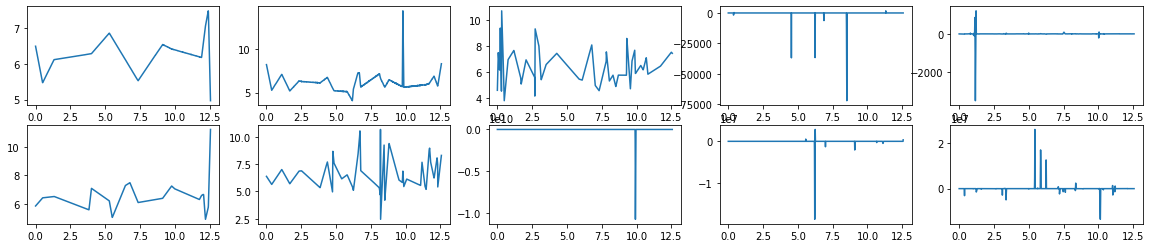

In [31]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(line_randdec, ns_axe=0, sat_axe=1)

In the graph just above we see an encoded linear function trying to be decoded with a linear regression trained with random input points, which does not mean anything.

In [32]:
sine_lindec = predict_all(models_lin, sin_e)
sine_sindec = predict_all(models_sin, sin_e)
sine_randdec = predict_all(models_rand, sin_e)

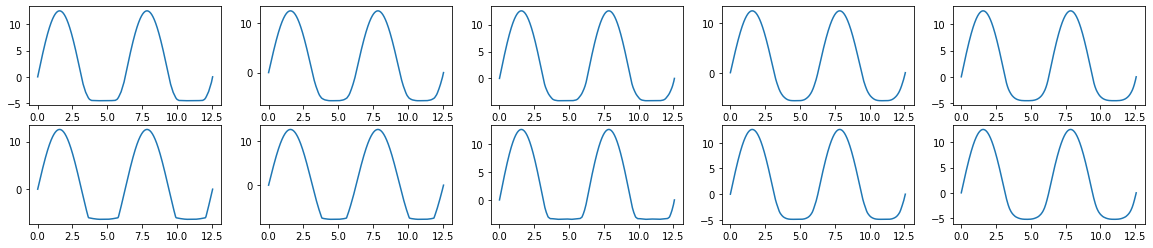

In [33]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(sine_lindec, ns_axe=0, sat_axe=1)

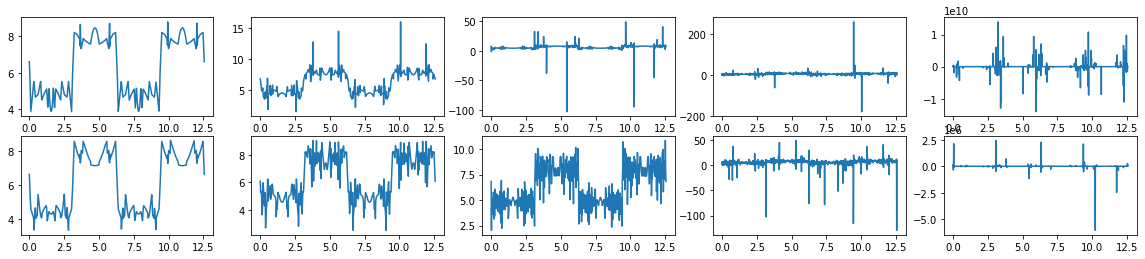

In [34]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(sine_sindec, ns_axe=0, sat_axe=1)

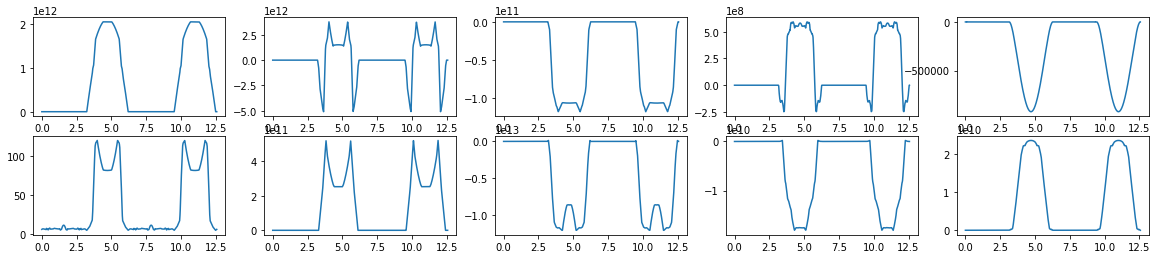

In [35]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(sine_randdec, ns_axe=0, sat_axe=1)

A courious note about the sine waves is that the decodings seem to have resemblance with a _Fourier Series approximation_

In [36]:
rande_lindec = predict_all(models_lin, rand_e)
rande_sindec = predict_all(models_sin, rand_e)
rande_randdec = predict_all(models_rand, rand_e)

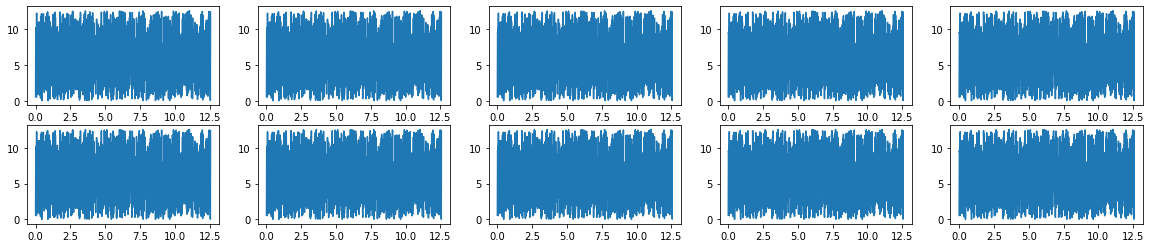

In [37]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(rande_lindec, ns_axe=0, sat_axe=1)

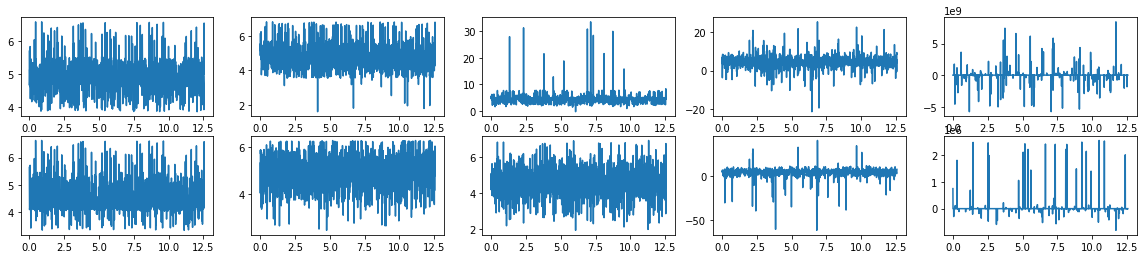

In [38]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(rande_sindec, ns_axe=0, sat_axe=1)

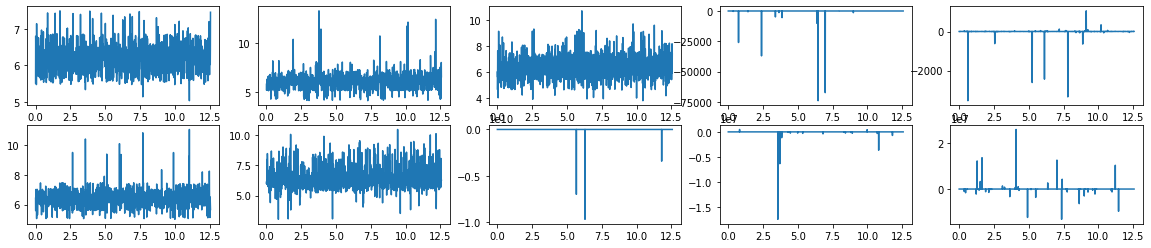

In [39]:
f, axes = plt.subplots(2,5, figsize=(20, 4))
plot_data(rande_randdec, ns_axe=0, sat_axe=1)

It can be observed that different Neural Ensembles (which contain different activation values for each neuron) make the decoding more or less difficult for the linear regressor decoder.

It is visible that the _Neural Ensemble_  initialization has an important effect in the decoding in most of the plots (it can be mainly observed in the plots to the right).

Also from the Sine waves, it can be observed that there are no negative values in the decoded functions, which means that the _tunning curves_ possible values (in the current case, only positive) restrict the domain that can be decoded. 

From this and some previous knowledge on how neural networks both artificial and biological learn it can be inferred that is important to correctly define the domains of the inputs and outputs.

It is also important to remark that in a real situation, the NN (either biological or artificial) both the network **and** the decoder learn. The present case of neuron values would be just the the initialization.

What happens in an ANN (Artificial Neural Network) is that all the neurons are trained, this means that the embeddings initial values (like the ones shown here)